### Run maxfuse on CDX tonsil - HCA tonsil

In [2]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

import seaborn as sns

##
import warnings
warnings.filterwarnings("ignore")

### read in protein data

In [3]:
df_clean = pd.read_csv('../data/feature_meta.csv', index_col=0) # already cleaned
xrange = [ 4, 5, 6, 7, 8]
yrange = [8, 9, 10, 11, 12, 13]
df_clean = df_clean[df_clean["X_view"].isin(xrange) & df_clean["Y_view"].isin(yrange)]
df_clean.shape

(102574, 54)

In [4]:
df_clean.columns

Index(['cellSize', 'HOECHST1', 'CD38', 'CD19', 'CD31', 'Vimentin', 'CD22',
       'Ki67', 'CD8', 'CD90', 'CD123', 'CD15', 'CD3', 'CD152', 'CD21',
       'cytokeratin', 'CD2', 'CD66', 'collagen IV', 'CD81', 'HLA-DR', 'CD57',
       'CD4', 'CD7', 'CD278', 'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9',
       'IGM', 'CD117', 'CD56', 'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63',
       'CD11b', 'CD1c', 'CD40', 'CD274', 'CD27', 'CD104', 'CD273', 'FAPalpha',
       'Ecadherin', 'PointNum', 'cluster.term', 'centroid_x', 'centroid_y',
       'X_view', 'Y_view'],
      dtype='object')

In [5]:
protein_adata = ad.AnnData(df_clean.iloc[:,2:-6].to_numpy(), dtype=np.float32) # remove meta info
protein_adata.var_names = df_clean.iloc[:,2:-6].columns

## read in rna data

In [6]:
seq = pd.read_csv('../data/tonsil_80k_5khvg_normed.csv')
meta_seq = pd.read_csv('../data/tonsil_80k_meta.csv')
vargene_name = pd.read_csv('../data/5k_vg_names.csv')

In [38]:
rna_adata = ad.AnnData(
    seq.T.to_numpy(), dtype=np.float32
)
rna_adata.obs_names = meta_seq['barcode']
rna_adata.var_names = vargene_name.iloc[:,0].values

In [39]:
correspondence = pd.read_csv('../data/protein_rna_name_conversionV11.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


In [40]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [41]:
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

print([rna_shared.shape, protein_shared.shape])

[(80000, 38), (102574, 38)]


In [42]:
# Make sure no column is static
mask = (
    (rna_shared.X.std(axis=0) > 0.1) 
    & (protein_shared.X.std(axis=0) > 0.1)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(80000, 29), (102574, 29)]


In [43]:
# process rna_shared
#sc.pp.normalize_total(rna_shared)
#sc.pp.log1p(rna_shared) # already from orignial data
sc.pp.scale(rna_shared)

In [44]:
sc.pp.scale(protein_shared)

In [45]:
rna_shared = rna_shared.X.copy()
protein_shared = protein_shared.X.copy()

In [46]:
# process all RNA features
#sc.pp.normalize_total(rna_adata)
#sc.pp.log1p(rna_adata)
#sc.pp.highly_variable_genes(rna_adata, n_top_genes=5000)
# only retain highly variable genes
#rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

In [47]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5] # these are fine since already using variable features
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5] # protein are generally variable

In [48]:
# inspect shape of the four matrices
print(rna_active.shape)
print(protein_active.shape)
print(rna_shared.shape)
print(protein_shared.shape)

(80000, 5000)
(102574, 46)
(80000, 29)
(102574, 29)


In [49]:
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [65]:
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=3,
    verbose=True
)

The first data is split into 3 batches, average batch size is 26666, and max batch size is 26668.
The second data is split into 3 batches, average batch size is 34191, and max batch size is 34192.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '1<->0', '1<->1', '1<->2', '2<->0', '2<->1', '2<->2'].


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 1'}, xlabel='Index', ylabel='Singular value'>)

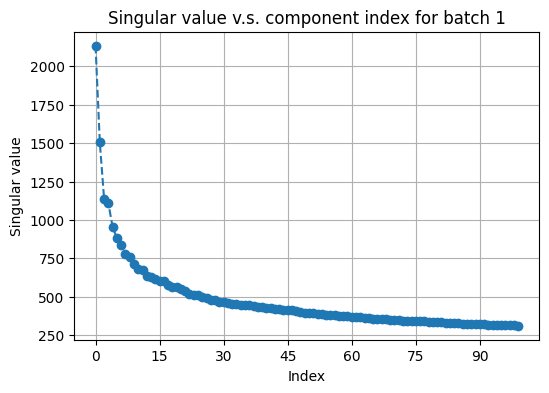

In [66]:
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

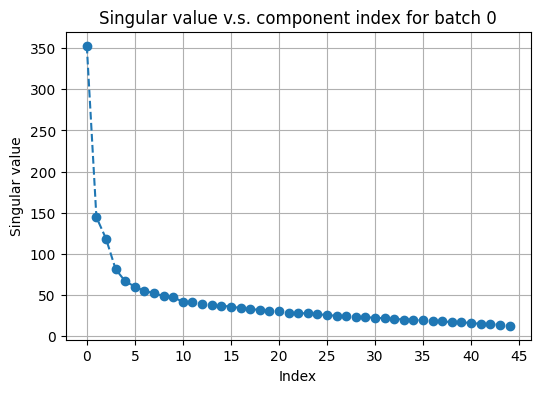

In [67]:
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

In [68]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=40,
    svd_components2=25,
    resolution1=1.5,
    resolution2=1.5,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 3...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Now at batch 1...
Metacell clustering finished!
Now at batch 2...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Graph clustering finished!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

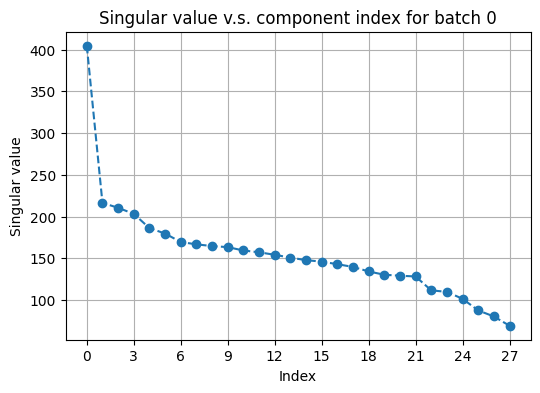

In [69]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

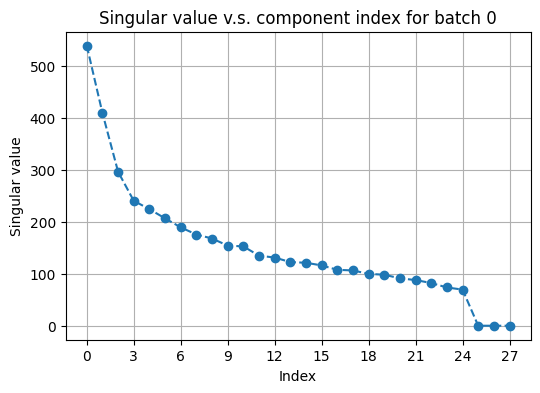

In [70]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

In [71]:
fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=20, svd_components2=20
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
Done!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

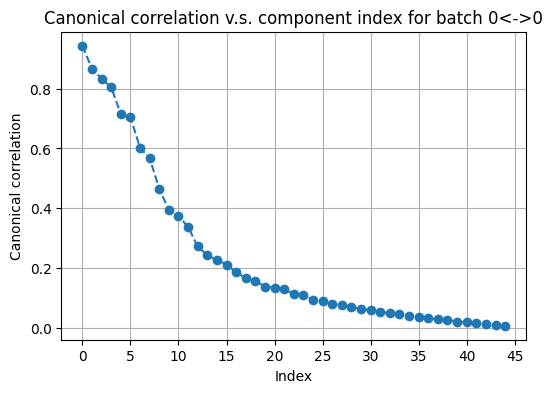

In [72]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=50,
    svd_components2=None,
    cca_components=45
)

In [73]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=35,
    cca_components=25,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
Done!


In [74]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.4)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
48102/80172 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
62705/80000 cells in arr1 are selected as pivots.
26465/102574 cells in arr2 are selected as pivots.
Done!


In [75]:
pivot_matching = fusor.get_matching(order=(2, 1),target='pivot')

In [76]:
cdx_labels = df_clean['cluster.term'].values
rna_labels = meta_seq['annotation_level_1'].values

In [77]:
r1 = rna_labels[pivot_matching[0]]
r2 = cdx_labels[pivot_matching[1]]

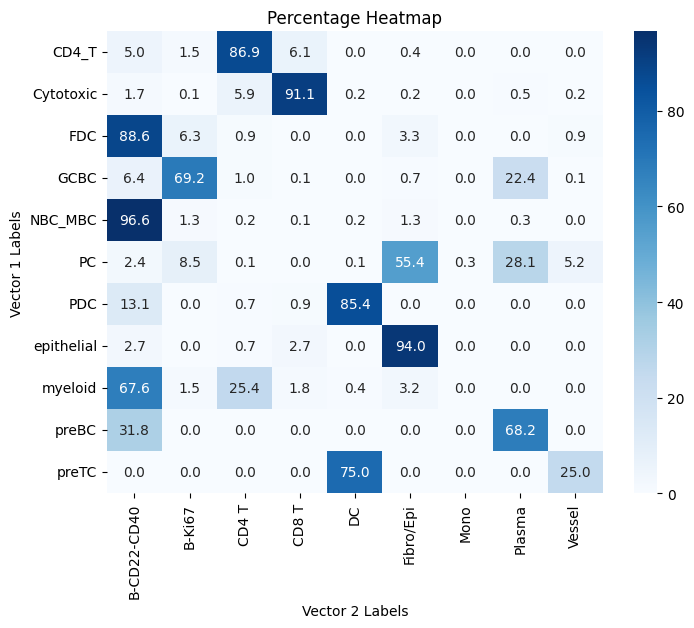

In [78]:
contingency_table = pd.crosstab(r1, r2)

# Normalize to percentages
percentage_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plot the percentage table as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(percentage_table, annot=True, cmap="Blues", fmt=".1f")
plt.title("Percentage Heatmap")
plt.xlabel("Vector 2 Labels")
plt.ylabel("Vector 1 Labels")
plt.show()

## considered using this version

In [79]:
fusor.propagate(
    svd_components1=40, 
    svd_components2=None, 
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
Done!


In [84]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0
)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
291690/291690 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [85]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

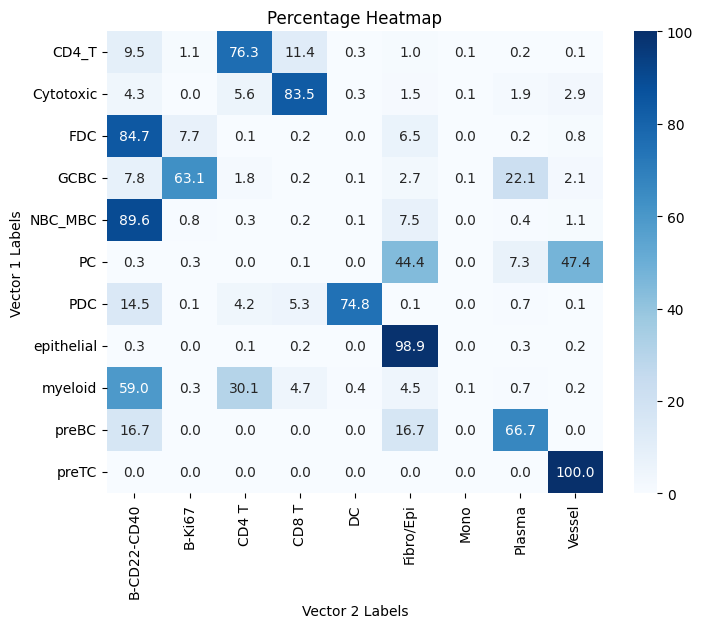

In [86]:
r1 = rna_labels[full_matching[0]]
r2 = cdx_labels[full_matching[1]]

contingency_table = pd.crosstab(r1, r2)

percentage_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
plt.figure(figsize=(8, 6))
sns.heatmap(percentage_table, annot=True, cmap="Blues", fmt=".1f")
plt.title("Percentage Heatmap")
plt.xlabel("Vector 2 Labels")
plt.ylabel("Vector 1 Labels")
plt.show()

In [92]:
df = pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
df = df.sort_values(by='mod2_indx', ascending=True, inplace=False)
df

,mod1_indx,mod2_indx,score
26465,25508,0,0.640351
26466,21189,1,0.661356
26467,35849,2,0.570782
26468,46740,3,0.483889
26469,69401,4,0.419584
...,...,...,...
102571,66933,102569,0.524388
26463,69857,102570,0.582903
102572,44548,102571,0.700501
102573,76017,102572,0.455703


In [96]:
meta_seq.loc[df['mod1_indx'].values,'annotation_level_1'].values

array(['NBC_MBC', 'Cytotoxic', 'GCBC', ..., 'Cytotoxic', 'CD4_T',
       'NBC_MBC'], dtype=object)

In [99]:
df_clean['maxfuse_res'] = meta_seq.loc[df['mod1_indx'].values,'annotation_level_1'].values
df_clean

,cellSize,HOECHST1,CD38,CD19,CD31,Vimentin,CD22,Ki67,CD8,CD90,...,CD273,FAPalpha,Ecadherin,PointNum,cluster.term,centroid_x,centroid_y,X_view,Y_view,maxfuse_res
cellLabelInImage,,,,,,,,,,,,,,,,,,,,,
1,32,6217.750000,0.059920,0.654999,0.032532,0.005859,1.000000,0.014643,0.020922,0.362975,...,0.012020,0.029262,0.149702,reg001_X04_Y08_Z08,B-CD22-CD40,3025.468750,3317.468750,4,8,NBC_MBC
3,36,7420.944444,0.022436,0.000000,0.042907,0.082692,0.000000,0.041960,1.000000,0.037367,...,0.010791,0.167671,0.039669,reg001_X04_Y08_Z08,CD8 T,3025.777778,2929.083333,4,8,Cytotoxic
4,69,3705.710145,0.024005,0.323413,0.010868,0.450219,0.166603,0.396156,0.158482,0.218550,...,0.016825,0.163844,0.166694,reg001_X04_Y08_Z08,B-Ki67,3026.173913,2979.115942,4,8,GCBC
5,90,4915.988889,1.000000,0.156977,1.000000,0.476991,0.060118,0.048008,0.129422,0.899862,...,0.275244,0.394651,1.000000,reg001_X04_Y08_Z08,Plasma,3026.588889,3074.522222,4,8,GCBC
6,52,3826.634615,0.620176,0.205964,0.707579,0.059099,0.148487,0.030935,0.603836,0.094042,...,0.760503,0.261925,0.236684,reg001_X04_Y08_Z08,CD8 T,3025.538462,3213.461538,4,8,Cytotoxic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283,82,7595.293000,0.070159,0.034225,0.252578,0.148361,0.007585,0.025806,0.517616,0.161589,...,0.988690,0.341328,0.071670,reg001_X08_Y13_Z06,CD4 T,9068.804878,9004.768293,8,13,CD4_T
4287,68,7144.544000,0.145626,0.156322,0.000000,0.008159,0.027210,0.121517,0.000000,0.245683,...,0.133935,0.401330,0.136000,reg001_X08_Y13_Z06,CD4 T,9069.147059,8452.102941,8,13,CD4_T
4288,66,6458.879000,0.082013,0.095079,0.100886,0.249687,0.000000,0.000000,1.000000,0.012907,...,0.139753,0.373069,0.345597,reg001_X08_Y13_Z06,CD8 T,9069.136364,8522.333333,8,13,Cytotoxic


In [100]:
df_clean.to_csv('../data/cdxton_withMF_res.csv')

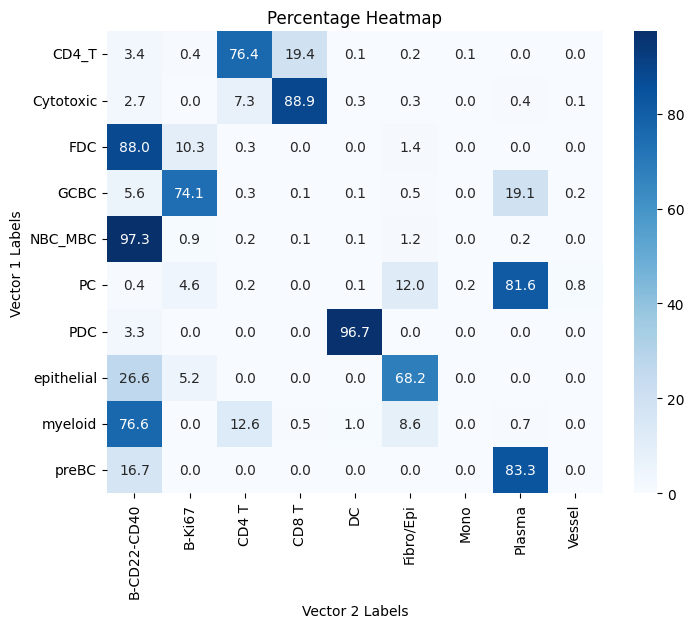

In [64]:
contingency_table = pd.crosstab(r1, r2)

# Normalize to percentages
percentage_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plot the percentage table as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(percentage_table, annot=True, cmap="Blues", fmt=".1f")
plt.title("Percentage Heatmap")
plt.xlabel("Vector 2 Labels")
plt.ylabel("Vector 1 Labels")
plt.show()

### test 1

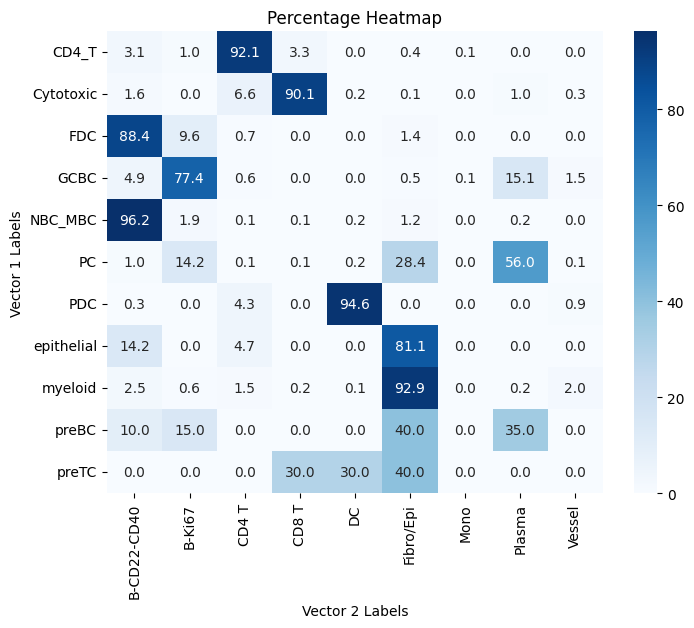

In [36]:
contingency_table = pd.crosstab(r1, r2)

# Normalize to percentages
percentage_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plot the percentage table as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(percentage_table, annot=True, cmap="Blues", fmt=".1f")
plt.title("Percentage Heatmap")
plt.xlabel("Vector 2 Labels")
plt.ylabel("Vector 1 Labels")
plt.show()